In [73]:
import os
import sys
import sqlite3
import networkx as nx
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import itertools
from collections import Counter
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
from operator import itemgetter 
import math

In [11]:
db = sqlite3.connect('../aip.db')
cursor = db.cursor()

In [12]:
queries = [
# The entire community - 0
(
    """
    SELECT id 
    FROM publications 
    WHERE year between 2009 AND 2018
    """,
    "systems-community"
),

# Workflow communities - 1
(
    """
    SELECT id 
    FROM publications 
    WHERE year between 2009 AND 2018
    AND (lower(title) LIKE '%workflow%' OR lower(abstract) LIKE '%workflow%') 
    AND (lower(title) LIKE '%schedul%' OR lower(abstract) LIKE '%schedul%')
    """,
    "workflow-community"
),

# Workflow formalisms - 2
(
    """
    SELECT id 
    FROM publications 
    WHERE year BETWEEN 2009 AND 2018 
    AND (lower(title) LIKE '%workflow%' OR lower(abstract) LIKE '%workflow%') 
    AND (
        (lower(title) LIKE '%formalism%' OR lower(abstract) LIKE '%formalism%') 
        OR (lower(title) LIKE '%language%' OR lower(abstract) LIKE '%language%')
    )
    """,
    "workflow-formalism-community"
),
    
# Workflow allocation - 3
(
    """
    SELECT id 
    FROM publications 
    WHERE (lower(title) LIKE '%workflow%' OR lower(abstract) LIKE '%workflow%') 
    AND (
        (lower(title) LIKE '%allocat%' OR lower(abstract) LIKE '%allocat%') 
        OR (lower(title) LIKE '%schedul%' OR lower(abstract) LIKE '%schedul%') 
        OR (lower(title) LIKE '%plan%' OR lower(abstract) LIKE '%plan%')
    ) 
    AND year BETWEEN 2009 AND 2018
    """,
    "workflow-allocation-community"
),

    
# Resource provisioning communities - 4
(
    """
    SELECT id 
    FROM publications 
    WHERE year BETWEEN 2009 AND 2018
    AND (lower(title) LIKE '%workflow%' OR lower(abstract) LIKE '%workflow%') 
    AND (
        lower(title) LIKE '%provision%' OR lower(abstract) LIKE '%provision%' 
        OR lower(title) LIKE '%autoscal%' OR lower(abstract) LIKE '%autoscal%'
    )
    """,
    "resource-provisioning-community"
),

# applications and services - 5
(
    """
    SELECT id 
    FROM publications 
    WHERE year BETWEEN 2009 AND 2018 
    AND (lower(title) LIKE '%cloud%' OR lower(abstract) LIKE '%cloud%') 
    AND (lower(title) LIKE '%service%' OR lower(abstract) LIKE '%service%')
    """,
    "applications-and-services-community"
),
]

In [13]:
def generate_graph_for_publication_query(search_query):
    query = """
    SELECT a.id, a.name, app.paper_id 
    FROM authors a JOIN author_paper_pairs app ON a.id = app.author_id
    WHERE app.paper_id IN (
        {}
    ) ORDER BY app.paper_id""".format(search_query)
    query_result = cursor.execute(query)
    author_list = query_result.fetchall()

    g = nx.Graph()
    author_set = set()
    author_id_to_label = dict()
    author_relation_set = set()
    author_list_len = len(author_list)
    i = 0
    
    num_relations = 0
    num_articles = 0
    while i < author_list_len:
        author_id = author_list[i][0]
        author_name = author_list[i][1]
        paper_id = author_list[i][2]
        num_articles += 1

        if author_id not in author_set:
            author_set.add(author_id)
            author_id_to_label[author_id] = author_name
            g.add_node(author_id, label=author_name)

        # Make sure to loop from i+1, to avoid self-loops yet still capture the many-to-many relationship
        for j in range(i+1, len(author_list)):
            co_author_id = author_list[j][0]
            co_author_name = author_list[j][1]
            co_paper_id = author_list[j][2]

            # Check if we reached a new article
            if co_paper_id != paper_id:
                break

            if co_author_id not in author_set:
                author_set.add(co_author_id)
                author_id_to_label[co_author_id] = co_author_name
                g.add_node(co_author_id, label=co_author_name)

            num_relations += 1
            # Put a relation of (smallest id, larger id) to only add an edge once later.
            # Doing this ensures we do not add a relationship more than once.
            if (min(author_id, co_author_id), max(author_id, co_author_id)) not in author_relation_set:
                author_relation_set.add((min(author_id, co_author_id), max(author_id, co_author_id)))
                g.add_edge(min(author_id, co_author_id), max(author_id, co_author_id))
        i += 1

    return g

In [29]:
search_query, community_string = queries[4]
graph = generate_graph_for_publication_query(search_query)

In [86]:
def generate_scatterplot_average_citation_count_vs_clique_size(g, community_string):
    minimum_clique_size = 1
    cliques = list(x for x in nx.find_cliques(g) if len(x) >= minimum_clique_size)
    
    avg_citation_count_vs_clique_size = []
    max_citation_count_vs_clique_size = []
    
    for clique in cliques:
        author_citation_count = []
        for author_id in clique:
            query = """
                SELECT TOTAL(n_citations)
                FROM publications p JOIN author_paper_pairs app ON p.id = app.paper_id
                WHERE app.author_id = ? 
                AND n_citations >= 0
            """
            query_result = cursor.execute(query, [author_id])
            author_sum = int(query_result.fetchone()[0])
            author_citation_count.append(author_sum)
        
        average_citation_count_per_author = np.average(author_citation_count)
        max_citation_count_per_author = np.max(author_citation_count)
        avg_citation_count_vs_clique_size.append((average_citation_count_per_author, len(clique)))
        max_citation_count_vs_clique_size.append((max_citation_count_per_author, len(clique)))

    
    # Generate the scatterplot
    
    # Set the limit to the next integer given the exponent, so 3.5*10^3 will become 4*10^3, etc.
    max_x_value = max(max_citation_count_vs_clique_size,key=itemgetter(0))[0]
    lower_exp = math.floor(math.log10(max_x_value))
    x_limit = math.ceil(max_x_value / 10 ** lower_exp) * (10 ** lower_exp)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(32,12)) 
    ax = axes[1]
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
    ax.scatter([d for d, _ in max_citation_count_vs_clique_size], [d for _,d in max_citation_count_vs_clique_size])
    ax.set_xlabel("Max Citation Count Per Author per Clique", fontsize=40)
    ax.set_ylabel("Clique size", fontsize=40)
    ax.set_xlim(0, x_limit)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(34)
    
    ax = axes[0]
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
    ax.scatter([d for d, _ in avg_citation_count_vs_clique_size], [d for _,d in avg_citation_count_vs_clique_size])
    ax.set_xlabel("Average Citation Count Per Author per Clique", fontsize=40)
    ax.set_ylabel("Clique size", fontsize=40)
    ax.set_xlim(0, x_limit)


    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(34)
    
    fig.savefig('cliques_size_vs_author_citation_{}.png'.format(community_string))

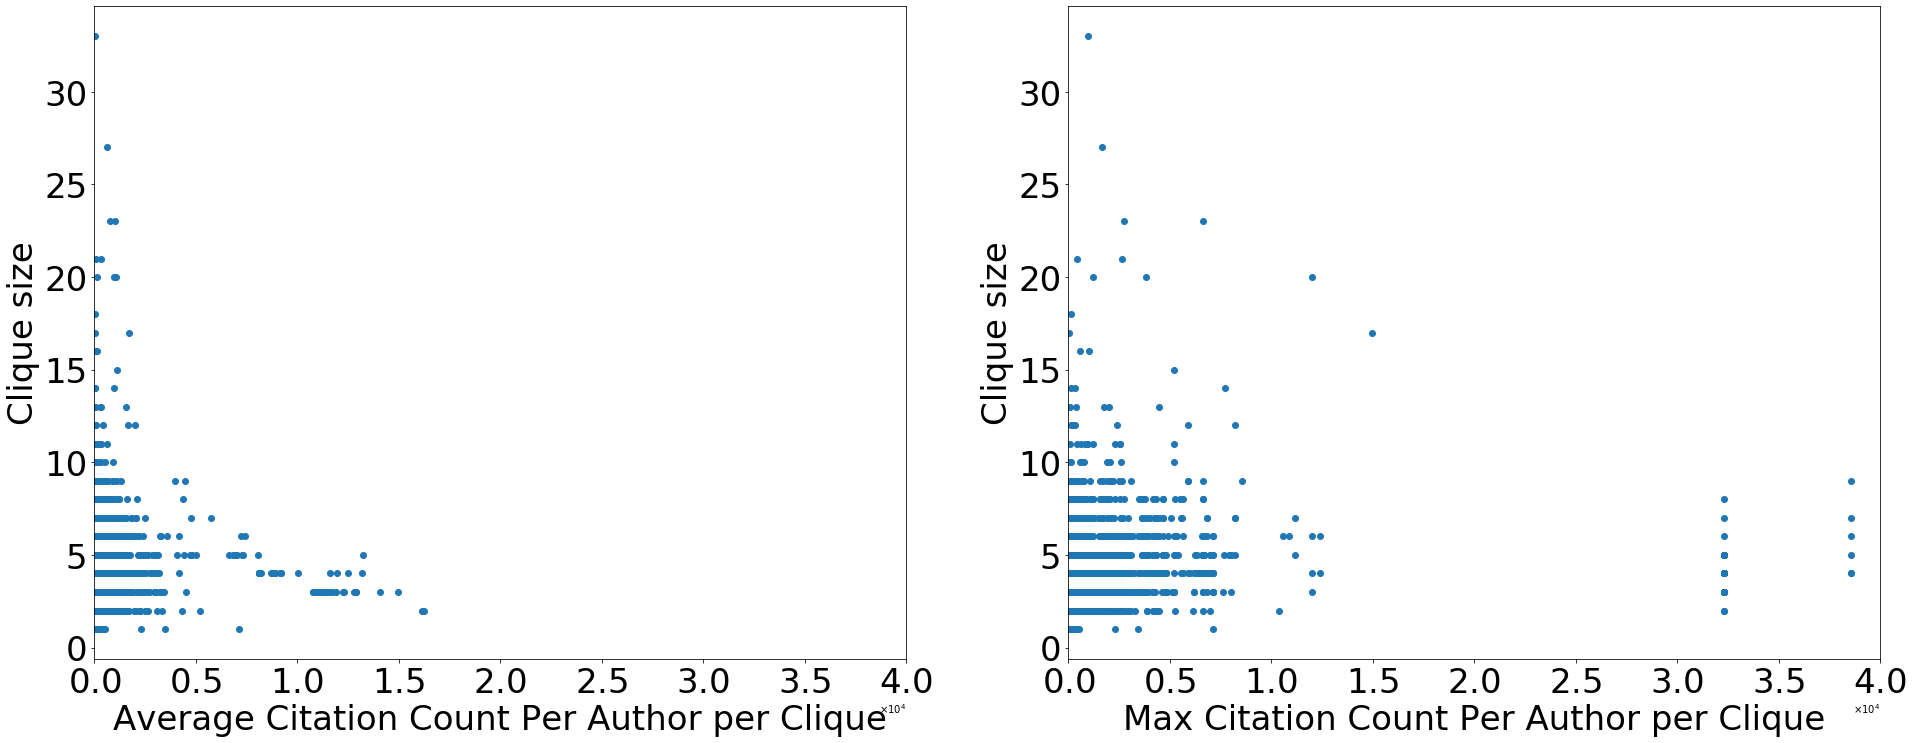

In [87]:
generate_scatterplot_average_citation_count_vs_clique_size(graph, community_string)

In [64]:
graphs_per_community = dict()
for search_query, community_string in queries:
    graph = generate_graph_for_publication_query(search_query)
    graphs_per_community[community_string] = graph

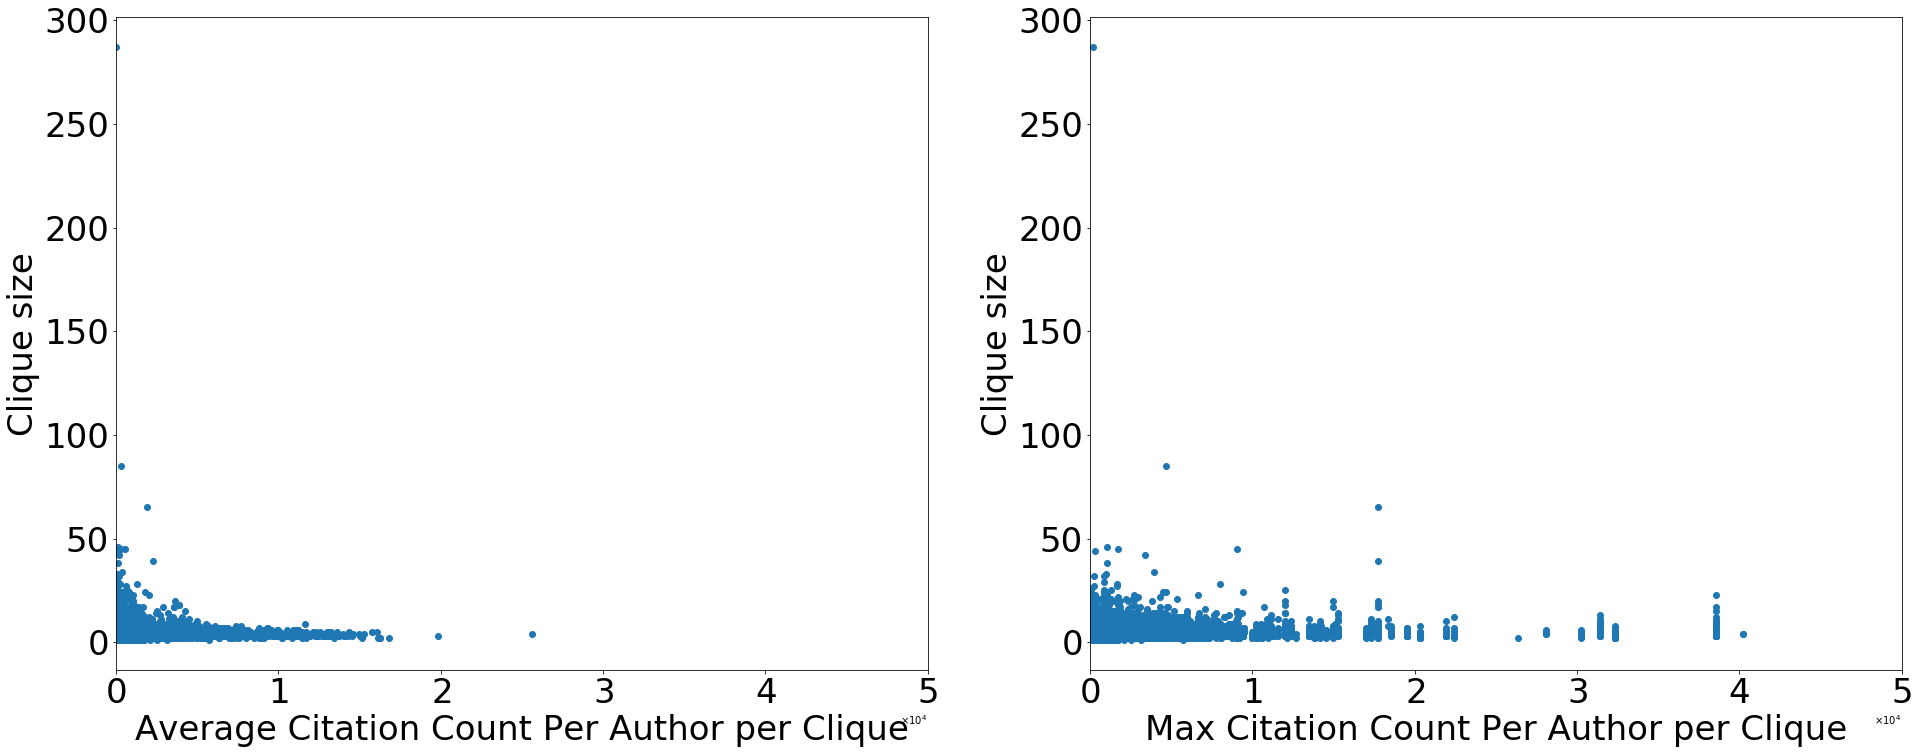

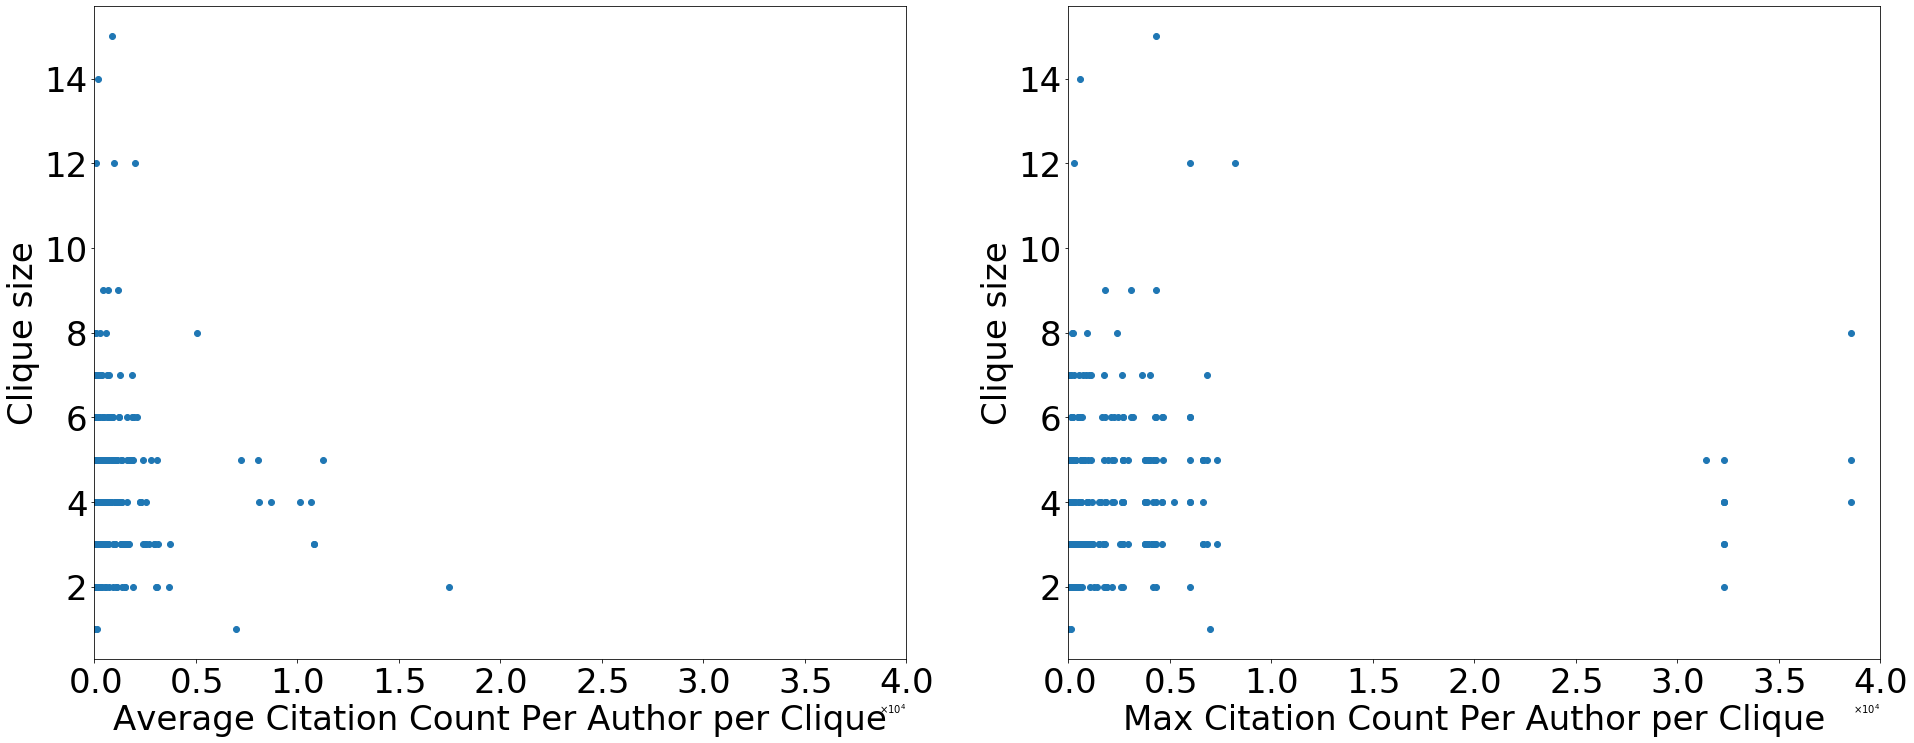

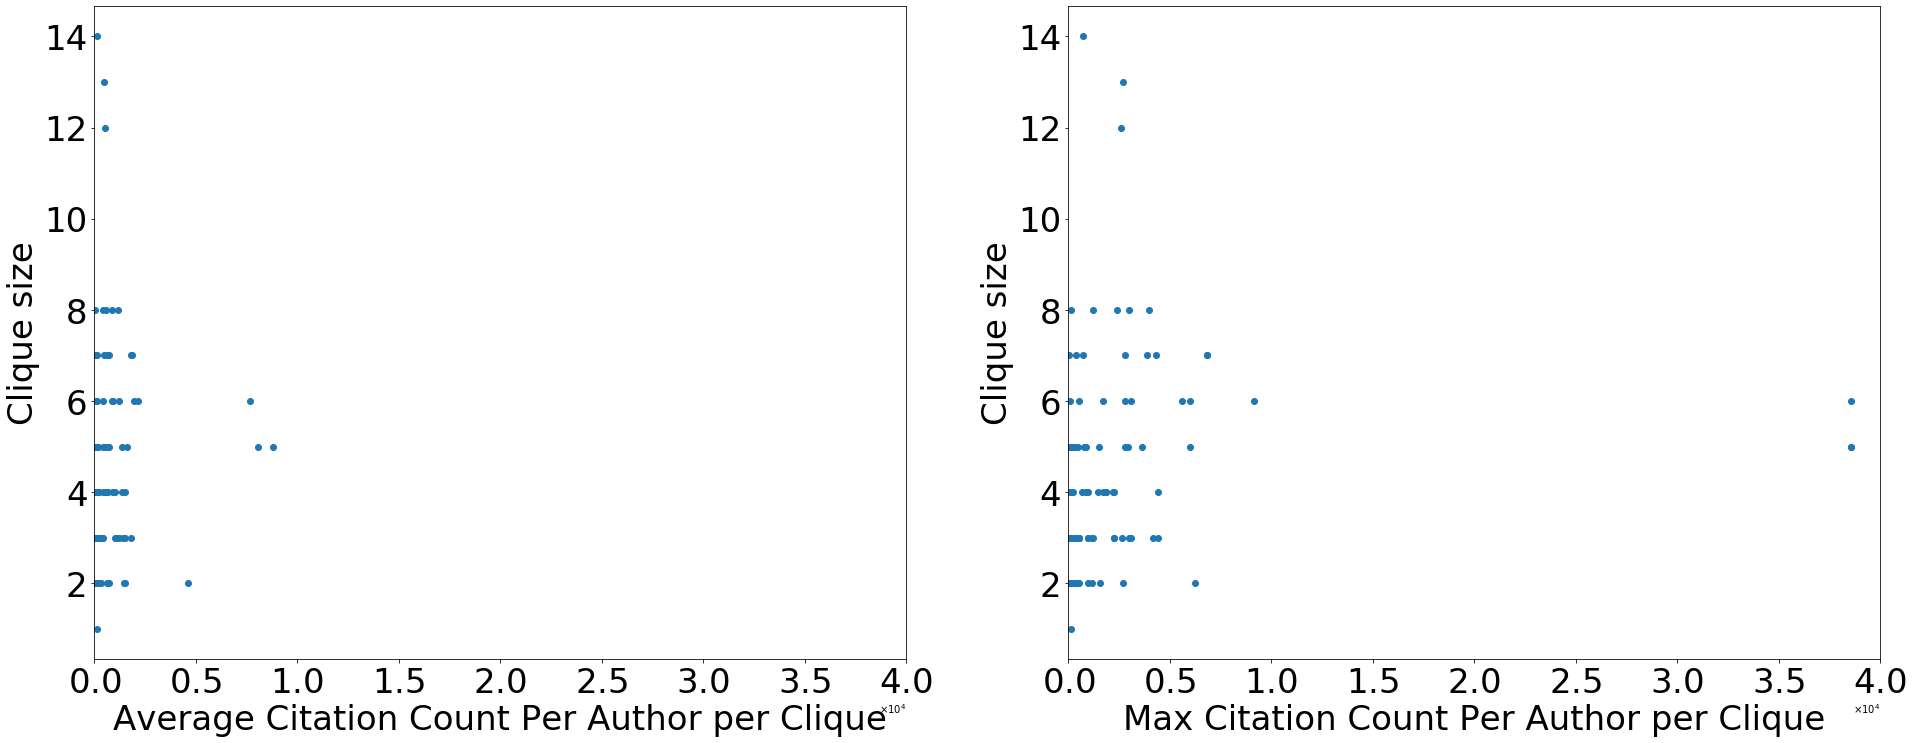

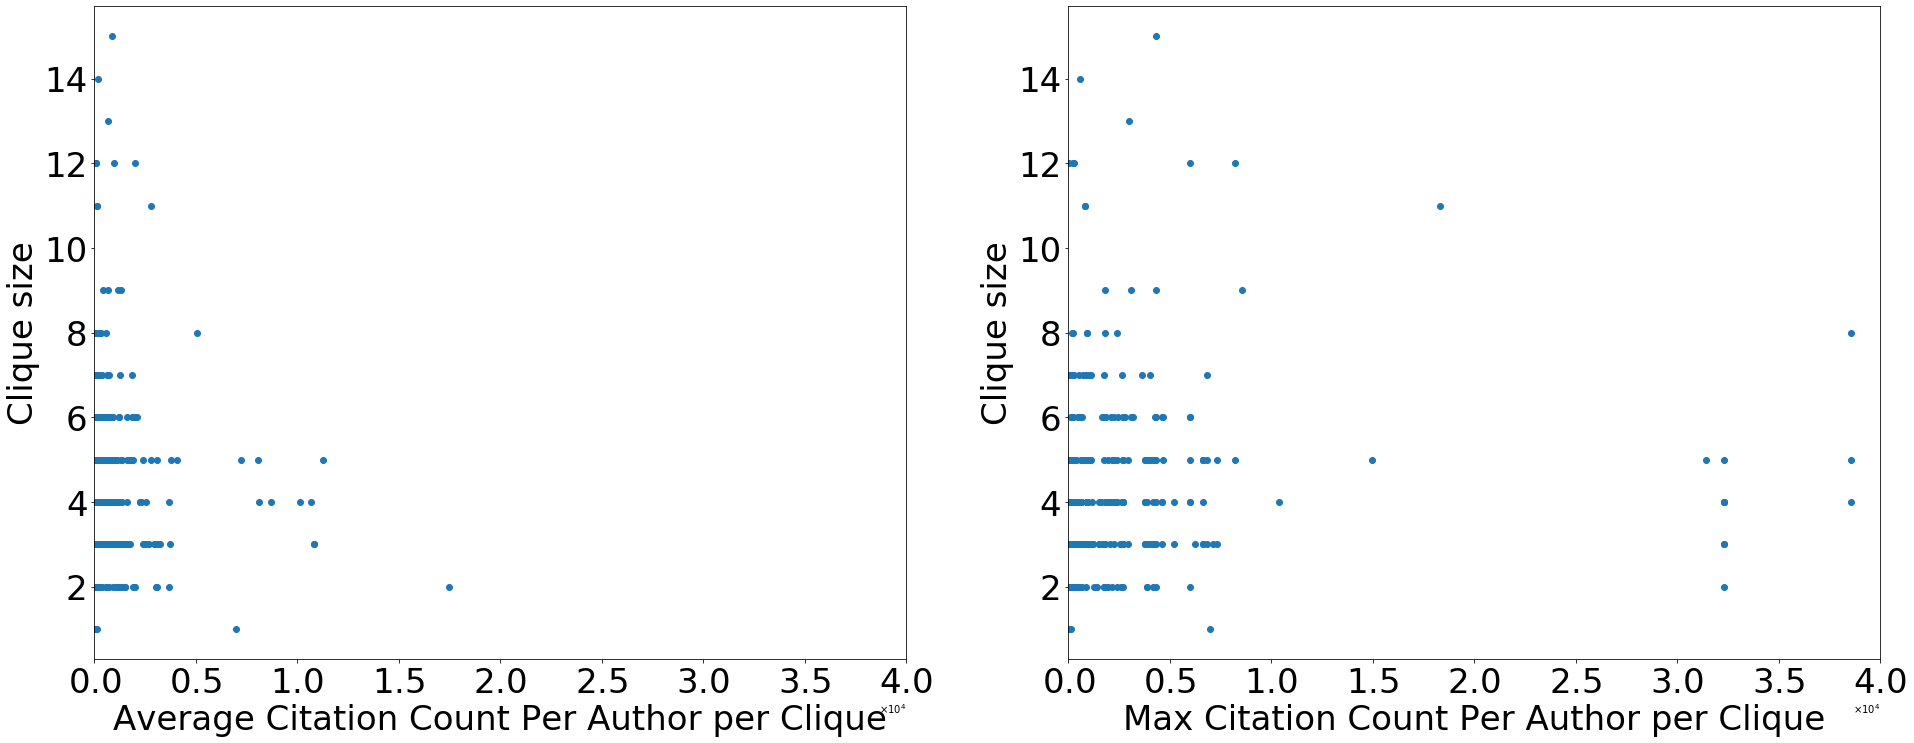

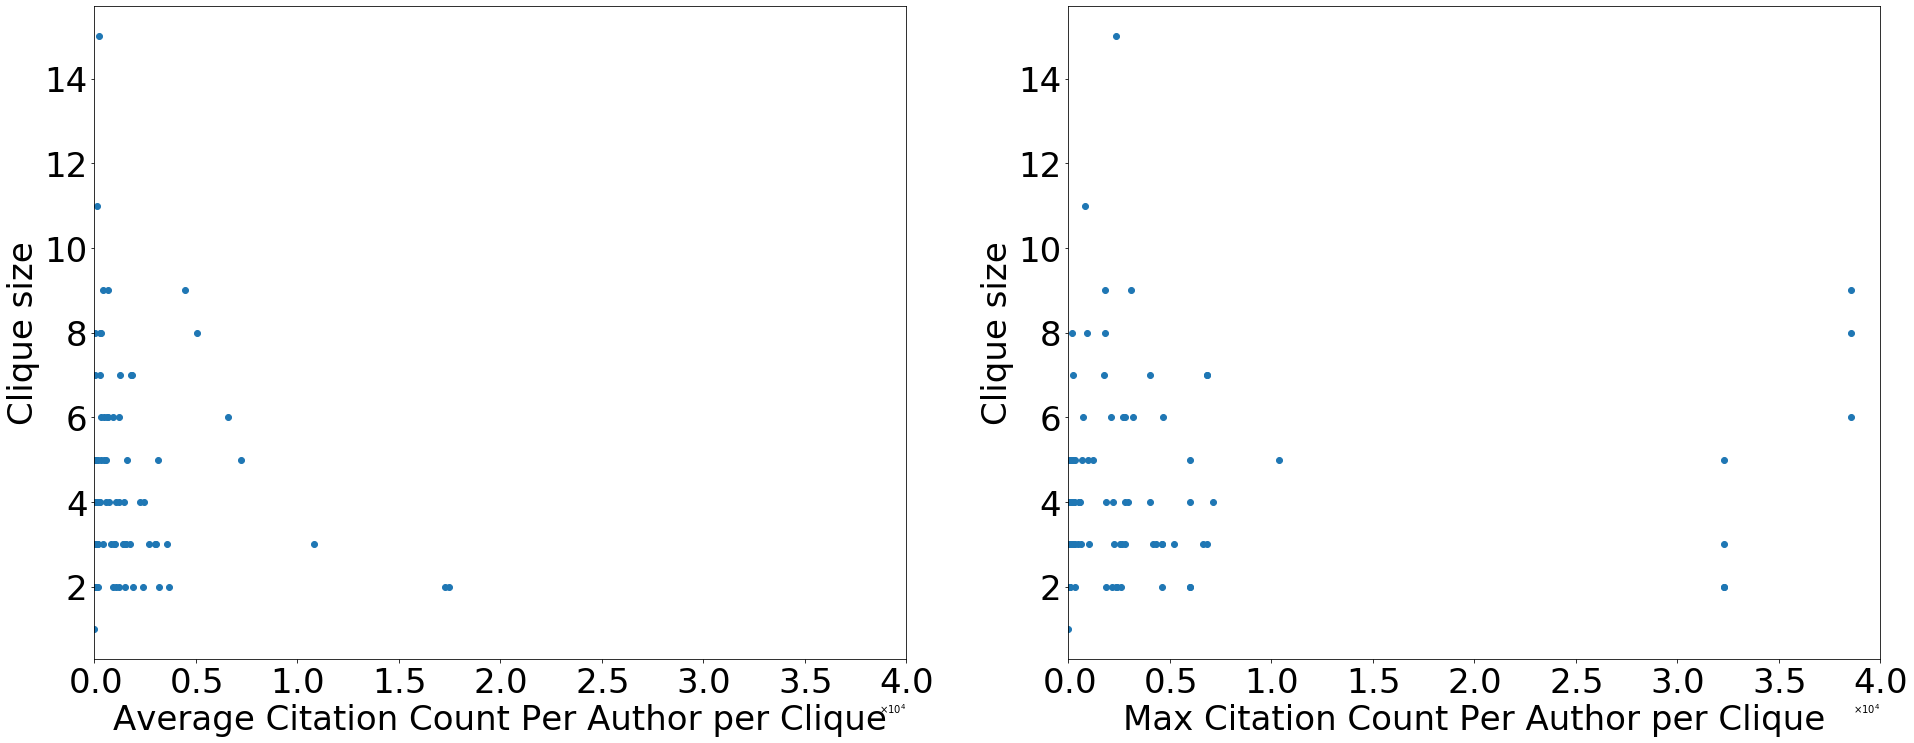

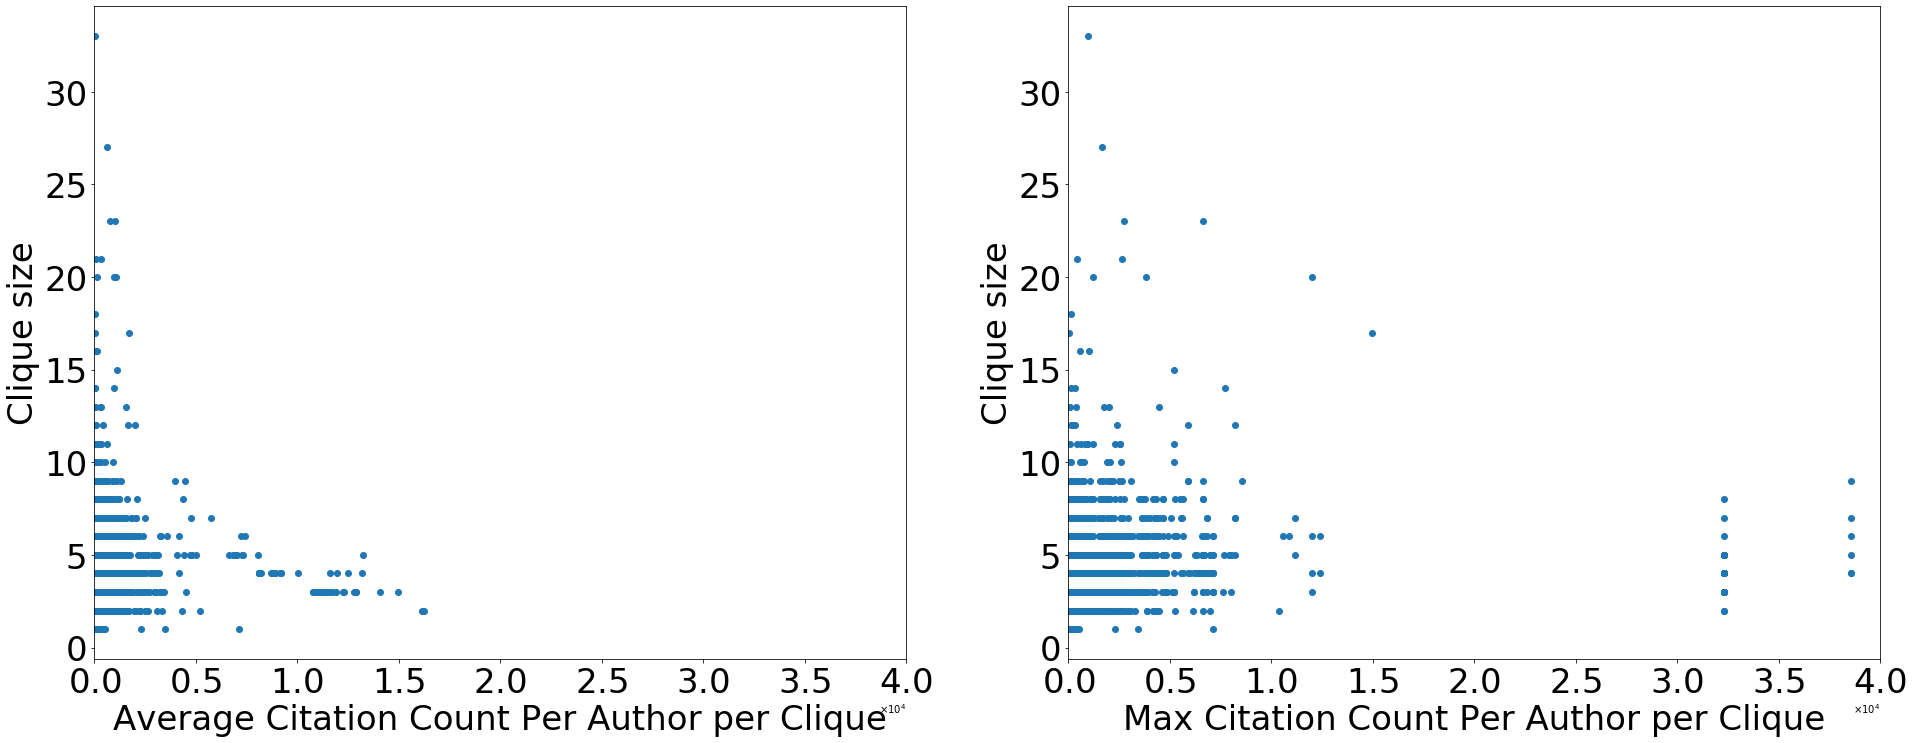

In [88]:
for community_string, graph in graphs_per_community.items():
    generate_scatterplot_average_citation_count_vs_clique_size(graph, community_string)